<a href="https://colab.research.google.com/github/zackives/upenn-cis-2450/blob/main/CIS_2450_Lab_7_Unsupervised_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 2450 Lab 7: Unsupervised Machine Learning

In this recitation, we will be demonstrating practical examples of using PCA (Principal Component Analysis) and K-Means clustering. We highly encourage you to revisit this notebook for HW 4.

# Imports

In [ ]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns

# A. K-Means Clustering

## K-Means Algorithm

K-Means is an unsupervised machine learning algorithm used for clustering data points into K groups based on their similarity.

### How it works:

1. **Initialization**:
   - Choose K, the number of clusters.
   - Randomly initialize K centroids in the feature space.

2. **Assignment Step**:
   - For each data point in the dataset:
     - Calculate the distance between the point and each centroid.
     - Assign the point to the cluster with the nearest centroid.

3. **Update Step**:
   - For each cluster:
     - Recalculate the centroid by taking the mean of all points assigned to that cluster.

4. **Convergence Check**:
   - Repeat steps 2 and 3 until one of the following conditions is met:
     - The centroids no longer move significantly (convergence).
     - A maximum number of iterations is reached.

5. **Optimization** (optional):
   - Repeat the entire process (steps 1-4) multiple times with different random initializations.
   - Choose the clustering result with the lowest total intra-cluster variance.

6. **Choosing optimal K**:
   - Look for an "elbow" in the plot to determine the optimal K (Elbow Plot).

### Advantages and Limitations:

Advantages:
- Simple to understand and fast to implement
- Scales well to large datasets
- Guarantees convergence

Limitations:
- Sensitive to initial centroid positions
- May converge to local optima
- Requires specifying K in advance

## Step 1: Creating fake data

In this section, we define points on a scatterplot to use as our artifical data.

In [ ]:
#number of clusters
num_clusters = 5

#size of the dataset
df_size = 1000

#randomize mean and standard deviation for each cluster
np.random.seed(0)
#scale mean to separate clusters
means = np.random.randn(num_clusters, 2) * 2
stds = np.random.randn(num_clusters, 2)

random_df = pd.DataFrame()

#for each cluster generate df_size/num_clusters points relocated based on that cluster's mean & std
for i in range(num_clusters):
    cluster_data = pd.DataFrame(np.random.randn(df_size // num_clusters, 2) * stds[i] + means[i], columns=['X', 'y'])
    random_df = pd.concat([random_df, cluster_data], ignore_index=True)

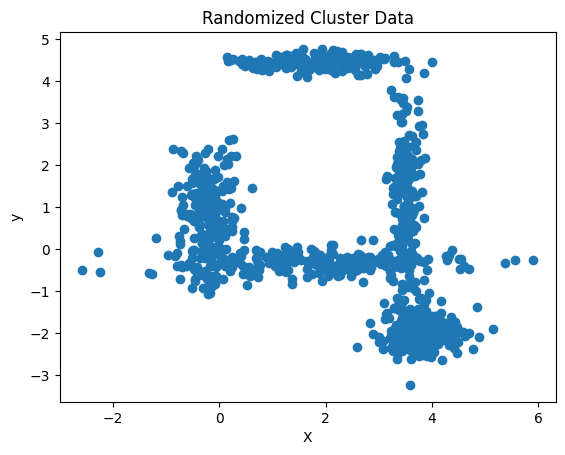

In [ ]:
#plot the data
plt.scatter(random_df['X'], random_df['y'])
plt.title('Randomized Cluster Data')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

By observation, we can see there are 4 to 5 major clusters. Let's see if K-Means identifies the same clusters we do!

## Step 2: Creating K-Means Model

In this section, we will fit a K-Means model with 5 clusters to the data.

Steps to K-Means Clustering in sklearn:

1. Standardize data! K-Means is sensitive to scaling.
2. Reduce dimensionality with PCA (if applicable)
3. Select number of clusters & instantiate model
4. Fit on data!

In [ ]:
# Head of Data
random_df.head()

,X,y
0,3.160363,1.750855
1,3.652621,-0.278997
2,3.855048,-1.314731
3,3.534696,0.528098
4,3.748892,2.937164


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# scale data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(random_df)

# choose # of clusters and instantiate model
kmeans = KMeans(n_clusters=5)

# fit model on scaled data
kmeans = kmeans.fit(scaled_df)

In [ ]:
# cluster values
clusters = kmeans.labels_.tolist()

kmeans_df = pd.DataFrame(scaled_df)
kmeans_df['cluster'] = clusters
kmeans_df.columns = ['X', 'y', 'cluster']
kmeans_df

,X,y,cluster
0,0.613817,0.437121,4
1,0.914474,-0.468150,4
2,1.038111,-0.930066,1
3,0.842449,-0.108203,4
4,0.973273,0.966190,4
...,...,...,...
995,-1.371556,0.399545,0
996,-1.319458,-0.239894,0
997,-1.390013,0.252437,0
998,-1.306986,-0.138542,0


Let's plot and shade the clusters to see if how the model grouped the clusters!

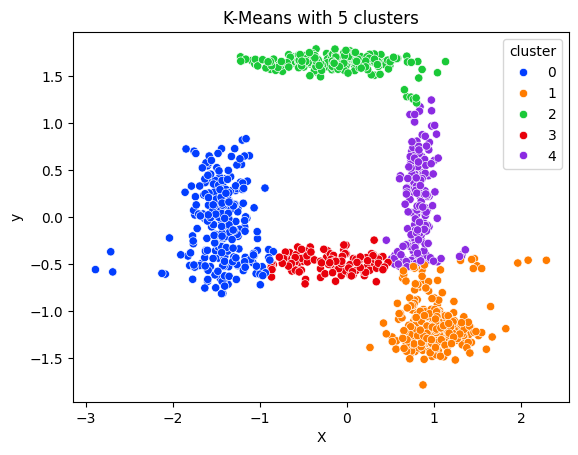

In [ ]:
import seaborn as sns
sns.scatterplot(x='X', y='y', hue='cluster', data=kmeans_df, palette='bright')
plt.title('K-Means with 5 clusters')
plt.show()

We can further experiment on different values of K. Let's say, for example, K=3.

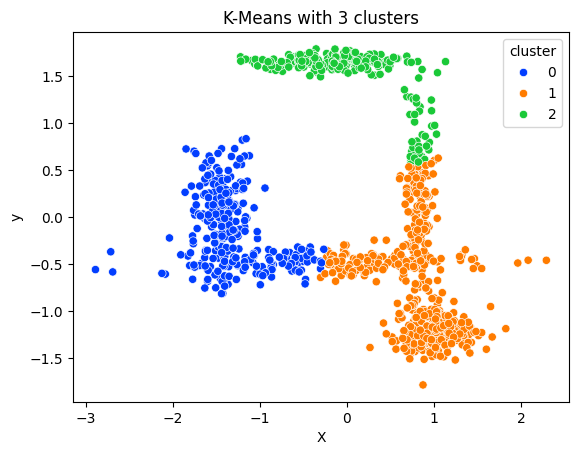

In [ ]:
# choose # of clusters and instantiate model
kmeans = KMeans(n_clusters=3)

# fit model on scaled data
kmeans = kmeans.fit(scaled_df)

# cluster values
clusters = kmeans.labels_.tolist()

kmeans_df = pd.DataFrame(scaled_df)
kmeans_df['cluster'] = clusters
kmeans_df.columns = ['X', 'y', 'cluster']

# Plot the clusters
sns.scatterplot(x='X', y='y', hue='cluster', data=kmeans_df, palette='bright')
plt.title('K-Means with 3 clusters')
plt.show()

But how do we know which K is the best choice for our number of clusters? In the next section, we'll discuss distortion and the elbow plot.

## Step 3: Choosing the number of clusters

Before we begin our discussion of elbow plots, we must first introduce **distortion**. The K-means algorithm chooses clusters to minimize distortion, which is the sum of the squared distances between each observation and its centroid. This is why the algorithm produces clusters of points close to each other, and not groups that are spread apart.

To choose the optimal number of clusters, k, we can use an elbow plot. An elbow plot compares the number of clusters on the x-axis, to the distortion on the y-axis. We want to choose the number of clusters that coincides with the 'elbow' of the plot, or where the plot flattens out. We can see an example of an elbow plot down below (source [Towards Data Science](https://towardsdatascience.com/elbow-method-is-not-sufficient-to-find-best-k-in-k-means-clustering-fc820da0631d#:~:text=The%20elbow%20method%20is%20a,cluster%20and%20the%20cluster%20centroid.) ).

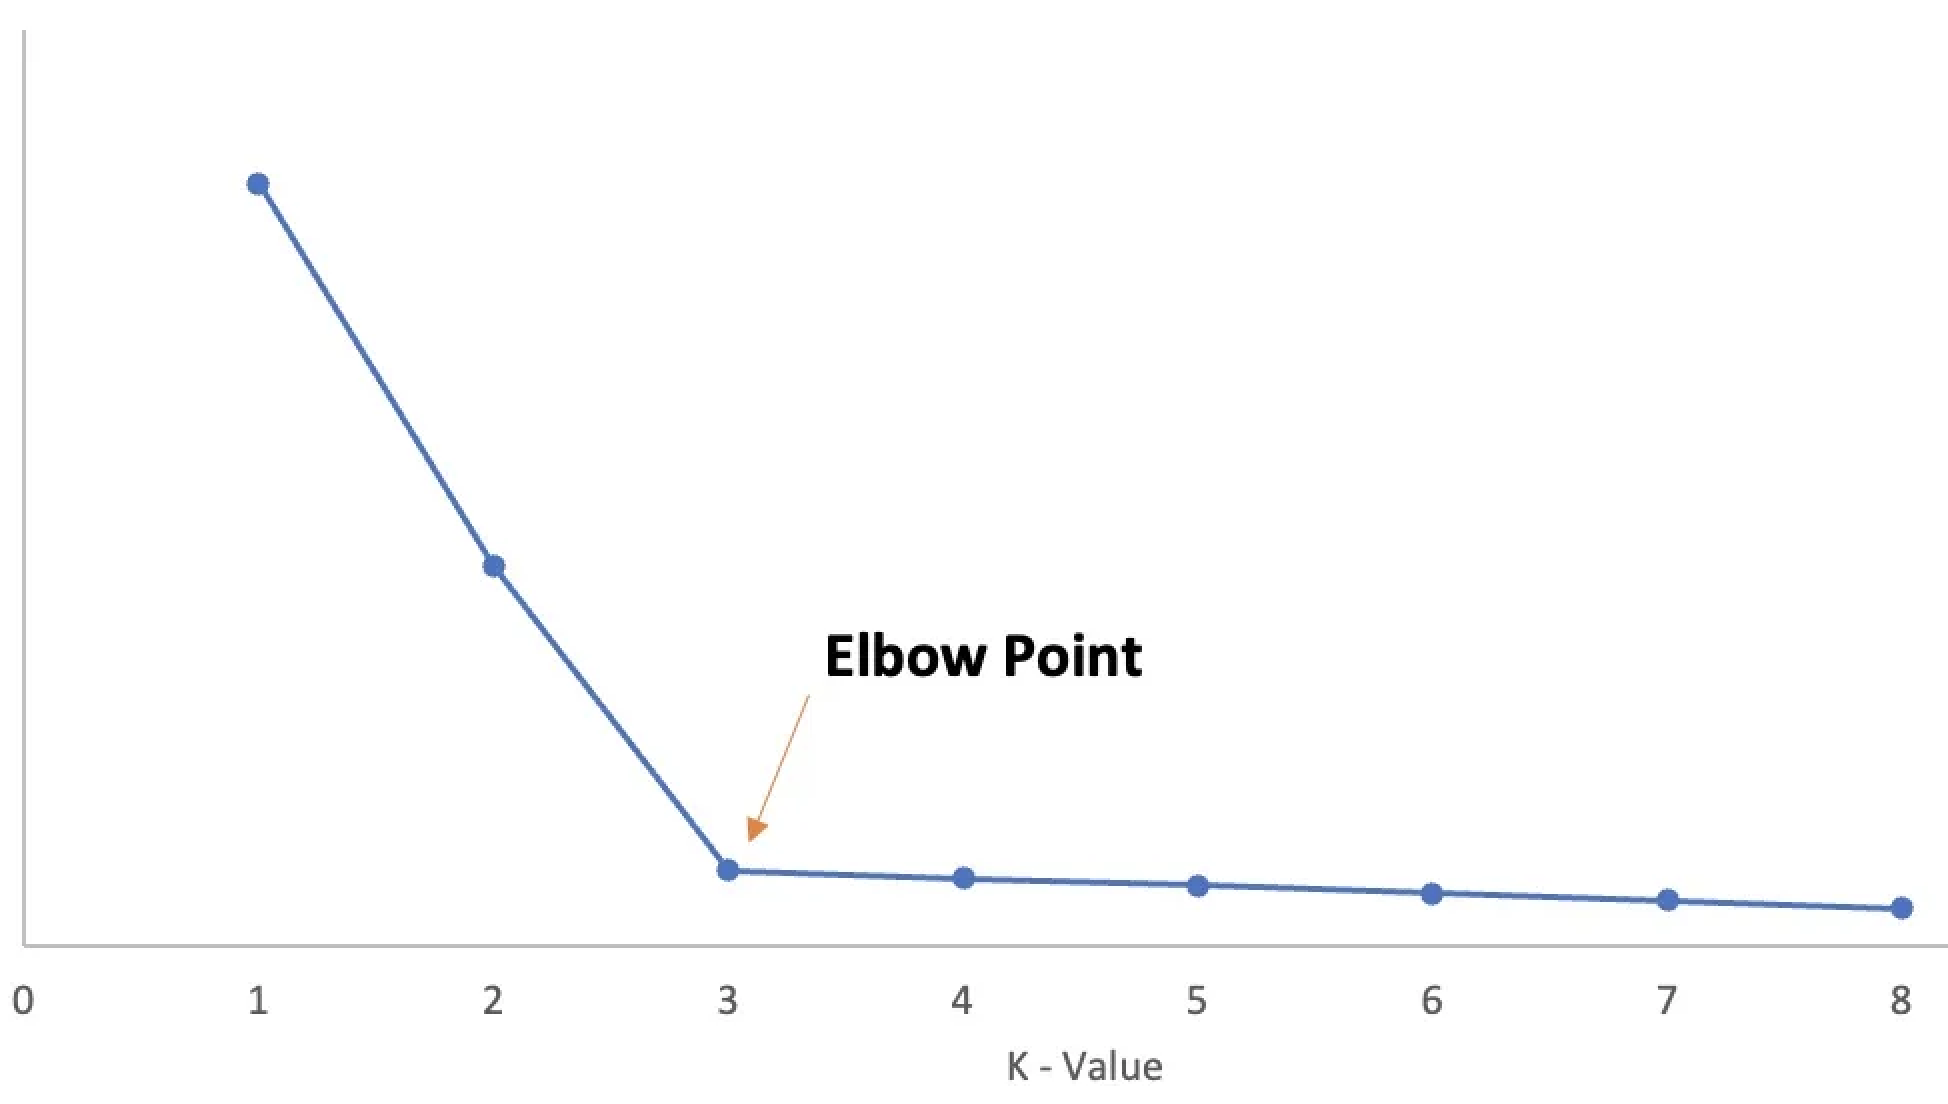

Now let's create an elbow plot for our own dataset!

In [ ]:
distortion_df = pd.DataFrame(columns=['k', 'distortion'])

for k in range(1, 10):
  # the inertia attribute is the distortion
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(scaled_df)
    new_distortion = pd.DataFrame({'k': [k], 'distortion': [kmeans.inertia_]})
    distortion_df = pd.concat([distortion_df, new_distortion], ignore_index=True)

<ipython-input-9-ef8c12b00df8>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  distortion_df = pd.concat([distortion_df, new_distortion], ignore_index=True)


In [ ]:
distortion_df

,k,distortion
0,1,2000.000000
1,2,961.764499
2,3,397.302091
3,4,330.920451
4,5,301.759793
5,6,167.542520
6,7,131.483585
7,8,103.104898
8,9,94.564424


Text(0.5, 1.0, 'Elbow Plot')

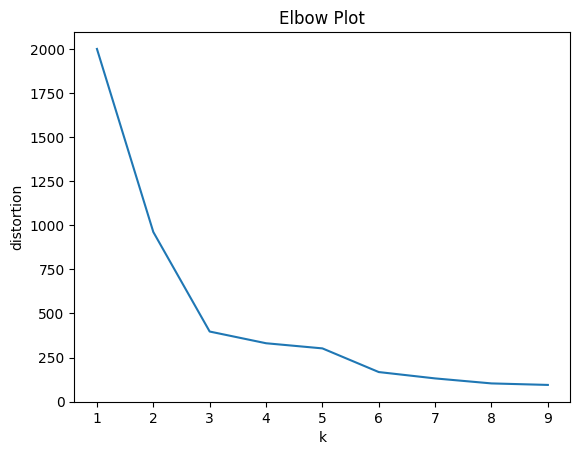

In [ ]:
sns.lineplot(distortion_df, x= 'k', y = 'distortion')
plt.title('Elbow Plot')

From the above elbow plot, we want to choose the value of K where the distortion starts to flatten out to balance between training accuracy and overfitting. Although this is not an exact science, we see the elbow occurs somewhere around 3.

# B. Principal Component Analysis

Principal Component Analysis (PCA) is an unsupervised machine learning technique used for dimensionality reduction and feature extraction. It transforms a dataset into a new coordinate system, where the axes (principal components) represent directions of maximum variance in the data.

### What is PCA?

PCA takes a matrix of data points with their features and outputs a new set of orthogonal feature vectors, ordered by their importance in capturing data variance. These new features, or principal components, are linear combinations of the original features.

### Why is PCA Useful?

1. **Dimensionality Reduction:** PCA can reduce the number of features while preserving most of the information, making it easier to work with high-dimensional data.

2. **Noise Reduction:** By discarding less significant components, PCA can effectively denoise datasets.

3. **Data Visualization:** PCA can project high-dimensional data onto lower dimensions (2D or 3D), facilitating visualization of complex datasets.

4. **Feature Extraction:** Principal components can be interpreted as new, synthetic features that capture key aspects of the data.

5. **Multicollinearity Handling:** In regression problems, PCA can address multicollinearity by creating uncorrelated features.

### Advantages and Limitations

**Advantages:**
- Scalable to large datasets
- Preserves data variability
- Can improve performance of subsequent machine learning tasks

**Limitations:**
- Assumes linear relationships between features
- Sensitive to feature scaling
- Resulting components may be difficult to interpret
- Some information loss is inevitable

In the next, we'll be demonstrating an example of PCA and when to use it.

### Step 1: When do we use Principal Component Analysis?

Let's take a look at one example of a dataset in which it is advantageous to use PCA. First we will perform all of the preprocessing and feature extraction (feel free to review this later; the main focus is on the PCA).

https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset/?select=Hotel+Reservations.csv

Download the data from the above Kaggle link to follow along! Make sure to upload the csv to your Colab environment.

In [ ]:
df_reservations = pd.read_csv('Hotel Reservations.csv')

In [ ]:
df_reservations

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


**NOTE:** Here we do one-hot encoding, which is important, but will be discussed in a later lecture. Basically, it is used to expand categorical features into multiple columns (one for each category), and assigns binary values to those categories. Don't worry about this for this recitation!

In [ ]:
# Drop "Booking_ID" column from `df_reservations`
df_reservations = df_reservations[['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights',
                                   'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'lead_time', 'arrival_year',
                                   'arrival_month', 'arrival_date', 'market_segment_type', 'repeated_guest', 'no_of_previous_cancellations',
                                   'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests', 'booking_status']]

In [ ]:
# Create dataframe 'encoded_df_reservations' that contains the appropriate one hot encoded columns and the original numerical columns
encoded_df_reservations = df_reservations.copy()
encoded_df_reservations = pd.get_dummies(encoded_df_reservations, columns = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type'])

Adding a boolean flag for if a reservation was cancelled or not.

In [ ]:
def canceled_checker(x):
  if x== 'Canceled':
    return 1
  else:
    return 0

encoded_df_reservations['booking_status'] = encoded_df_reservations['booking_status'].apply(canceled_checker)

# Drop null values from the DataFrame
encoded_df_reservations = encoded_df_reservations.dropna()

# Optionally, reset the index after dropping rows
encoded_df_reservations = encoded_df_reservations.reset_index(drop=True)

Here we divide the data into train and test data. Don't worry about this here, but this will be important for upcoming homeworks, so please feel free to revisit this later on.

In [ ]:
features = encoded_df_reservations[['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights',
                                   'type_of_meal_plan_Meal Plan 1', 'type_of_meal_plan_Meal Plan 2', 'type_of_meal_plan_Meal Plan 3',
                                   'type_of_meal_plan_Not Selected',
                                   'required_car_parking_space', 'room_type_reserved_Room_Type 1', 'room_type_reserved_Room_Type 2',
                                   'room_type_reserved_Room_Type 3', 'room_type_reserved_Room_Type 4', 'room_type_reserved_Room_Type 5',
                                   'room_type_reserved_Room_Type 6', 'room_type_reserved_Room_Type 7', 'lead_time', 'arrival_year',
                                   'arrival_month', 'arrival_date', 'market_segment_type_Aviation', 'market_segment_type_Complementary',
                                   'market_segment_type_Corporate', 'market_segment_type_Offline', 'market_segment_type_Online',
                                   'repeated_guest', 'no_of_previous_cancellations',
                                   'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']]

In [ ]:
target = encoded_df_reservations['booking_status']

In [ ]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = seed)

## Step 2: Fit the PCA to training data
Once we have identified that it is advantageous to use PCA, we will start by fitting the PCA model to our training data. This will return a list of vectors, organised by their explained variance. (Therefore the first few vectors are the most important for explaining the data)

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Recall that ***PCA is NOT scale-invariant.*** This means that before we continue, we must

In [ ]:
#Intermediate step to address fact that PCA is not scale-invariant
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate and Fit PCA
pca = PCA()
X2 = pca.fit(X_train_scaled)

## Step 3: How many PCA components to include?
One of the goals of PCA is to reduce the dimensionality of the dataset by expressing points along fewer vectors. We do so by eliminating some of the less important vectors in our new transformed vector space that explain less variance in the data.

In order to determine how many vectors to eliminate, we will be using the **Cumulative Explained Variance Ratios**. This quantity expresses how much variance is explained by a certain number of principal components.

First, we can compute this by first getting the explained variance ratio for each component. This can be obtained by calling ```pca.explained_variance_ratio```, which is a list in which each term represents the proportion of the total variance explained by that principal component.

Then, we use the ```np.cumsum()``` function to return a cumulative list of these values.

In [ ]:
# TO-DO: Save the explained variance ratios into variable called "explained_variance_ratios"
explained_variance_ratios = pca.explained_variance_ratio_

# TO-DO: Save the CUMULATIVE explained variance ratios into variable called "cum_evr"

## tutorial cumulative sum used: https://www.digitalocean.com/community/tutorials/numpy-cumsum-in-python
cum_evr = np.cumsum(explained_variance_ratios)

As a general rule of thumb, we select the number of components such that **80%** of the cumulative explained variance is maintained. This is because:
1. We don't want there to be too many components or else we will not perform dimensionality and noise reduction.
2. We don't want to exclude too many components, otherwise our new vector space will fail to encapsulate variations in the data, which will be important for machine learning/regression models to encapsulate.

In the below code, we will generate a graph to determine how many components to keep based on this 80% threshold.

Text(0.5, 1.0, 'Cumulative Explained Variance vs. Number of PCA Components')

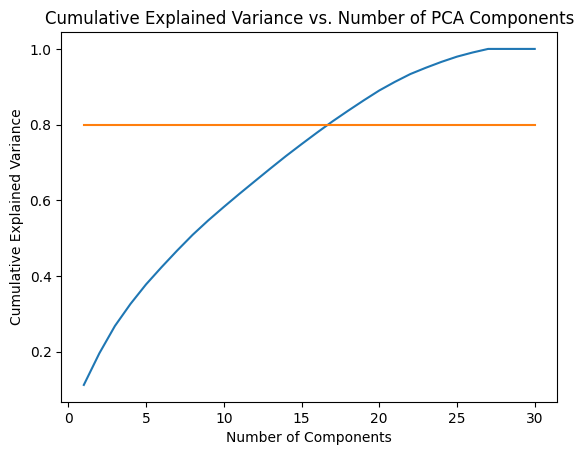

In [ ]:
# TO-DO: find optimal num components to use (n) by plotting explained variance ratio

x_ticks = np.arange(len(cum_evr)) + 1

plt.plot(size = [8, 6])
sns.lineplot(x = x_ticks, y = cum_evr)
sns.lineplot(x = x_ticks, y = 0.8 * np.ones(len(cum_evr)))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of PCA Components')

## Step 4: Apply the PCA to the train and test data

Now that we have identified the number of components to keep, we will now train a new PCA model, which will keep the number of components that we have specified.

1. First, we train the model on the train data and transform the training data.
2. Secondly, we transform the test data (but do not perform training!).

In [ ]:
# TO-DO: Get transformed set of principal components on x_test
## Based on the graph (I also checked this with the actual numbers, it seems that 1
## 17 components, or 16 on the array is appropriate for this problem)

# 1. Refit and transform on training with parameter n (as deduced from the last step)
n = 17
pca = PCA(n_components = n)
X_train_pca = pca.fit_transform(X_train_scaled)

# 2. Transform on Testing Set and store it as `X_test_pca`
X_test_pca = pca.transform(X_test_scaled)

## What Happens Next?

After performing PCA, we would typically run our regression/machine learning models on the data.